In [ ]:
!pip install pyarrow --quiet
!pip install yfinance --quiet

# 1.0 Imports

In [ ]:
import os
import requests
import urllib.request
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')

In [ ]:
API_KEY = 'varos_9e52082dcd5a5fa1086bb87dc3bafdf9'
HEADERS = {'accept': 'application/json',
           'X-API-KEY': API_KEY}

URL_BASE = 'https://api.fintz.com.br'
PARAMS = {'ticker': 'VALE3', 'dataInicio': '2010-01-01'}

endpoint = URL_BASE + '/bolsa/b3/avista/cotacoes/historico'
res = requests.get(endpoint, headers=HEADERS, params=PARAMS)

if res.status_code == 200:
    df = pd.DataFrame(res.json())
    print("API request successful!")
else:
    print(f"Error: API request failed with status code {res.status_code}")
    print(res.json())

API request successful!


# 2.0 Data Ingestion

In [ ]:
def load_stock_data_from_api(base_url: str, ticker: str, start_date: str, end_date: str, api_key: str | None = None) -> pd.DataFrame:
    """Loads historical stock data via REST API.

    Parameters

    ---------
    base_url : str
    API endpoint
    ticker : str
    Asset code (e.g., VALE3)
    start_date : str
    Start date (YYYY-MM-DD)
    end_date : str
    End date (YYYY-MM-DD)
    api_key : str, optional
    API authentication key

    Returns

    -------
    pd.DataFrame
    DataFrame with historical data

    """
    params = {
        "ticker": ticker,
        "start_date": start_date,
        "end_date": end_date
    }

    headers = {}
    if api_key:
        headers["Authorization"] = f"Bearer {api_key}"

    response = requests.get(base_url, params=params, headers=headers)
    response.raise_for_status()

    data = response.json()

    df = pd.DataFrame(data)
    df.columns = (df.columns.str.replace(r'([a-z])([A-Z])', r'\1_\2', regex=True).str.lower())

    return df


# 3.0 Data Preparation

In [ ]:
def prepare_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Prepare the base dataframe:
    - sort by date
    - calculate daily return
    - define binary target (high / not high)
    """
    df = df.copy()

    df['data'] = pd.to_datetime(df['data'])
    df = df.sort_values('data').reset_index(drop=True)

    df['retorno_1d'] = df['preco_fechamento_ajustado'].pct_change()
    df['target'] = (df['retorno_1d'].shift(-1) > 0).astype(int)

    return df

# 4.0 Feature Engineering

In [ ]:
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Creates classic financial features:
    - returns
    - volatility
    - moving averages
    - z-score
    - volume
    """
    df = df.copy()

    # Retornos
    for w in [1, 3, 5, 10, 20]:
        df[f'retorno_{w}d'] = df['preco_fechamento_ajustado'].pct_change(w)

    # Volatilidade
    for w in [5, 10, 20]:
        df[f'vol_{w}d'] = df['retorno_1d'].rolling(w).std()

    # Médias móveis
    for w in [5, 10, 20]:
        df[f'ma_{w}d'] = df['preco_fechamento_ajustado'].rolling(w).mean()

    # Z-score
    df['zscore_20d'] = (
        (df['preco_fechamento_ajustado'] -
         df['preco_fechamento_ajustado'].rolling(20).mean()) /
        df['preco_fechamento_ajustado'].rolling(20).std()
    )

    # Liquidez
    df['volume_log'] = np.log1p(df['volume_negociado'])
    df['negocios_log'] = np.log1p(df['quantidade_negocios'])

    return df.dropna().reset_index(drop=True)

# 5.0 Train-Test Split

In [ ]:
def temporal_train_test_split(
    df: pd.DataFrame,
    target_col: str,
    split_ratio: float = 0.8
):
    """
    Split temporal without leakage + normalization
    """
    split = int(len(df) * split_ratio)

    X = df.drop(columns=['ticker', 'data', target_col])
    y = df[target_col]

    X_train, X_test = X.iloc[:split], X.iloc[split:]
    y_train, y_test = y.iloc[:split], y.iloc[split:]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test, split

In [ ]:
def make_sequences(X, y, window: int = 20):
    """
    Creates time windows for sequential models.
    """
    Xs, ys = [], []

    for i in range(window, len(X)):
        Xs.append(X[i - window:i])
        ys.append(y.iloc[i])

    return np.array(Xs), np.array(ys)

In [ ]:
def build_lstm_model(input_shape):
    """
    Creates a simple and standardized LSTM model.
    """
    model = keras.Sequential([
        keras.layers.Input(shape=input_shape),
        keras.layers.LSTM(128, return_sequences = True),
        keras.layers.LSTM(64, return_sequences = False),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['accuracy', keras.metrics.AUC(name='auc')]
    )

    return model

In [ ]:
def backtest_strategy(df_bt: pd.DataFrame, prob, quantile: float = 0.9):
    """
    Performs backtesting with dynamic thresholding by quantile.
    """
    threshold = np.quantile(prob, quantile)

    df_bt = df_bt.copy()
    df_bt['signal'] = (prob >= threshold).astype(int)
    df_bt['retorno_modelo'] = df_bt['retorno_1d'] * df_bt['signal']

    return df_bt

# 6.0 Metrics

In [ ]:
def plot_drawdown(returns: pd.Series):
    """
    Plot drawdown of the strategy
    """
    cum_returns = (1 + returns).cumprod()
    drawdown = cum_returns / cum_returns.cummax() - 1

    drawdown.plot(figsize=(10, 4), color='red')
    plt.title('Drawdown da Estratégia')
    plt.ylabel('Drawdown')
    plt.grid(True)
    plt.show()

In [ ]:
def compute_hits_and_errors(df: pd.DataFrame) -> pd.DataFrame:
    """
    Acerto = modelo operou e o target real foi positivo
    """
    df = df.copy()

    df['acertos'] = (
        (df['signal'] == 1) &
        (df['target_actual'] == 1)
    )

    return df

In [ ]:
def hit_error_metrics(df: pd.DataFrame):
    """
    Calcula taxa de acerto e erro considerando apenas trades.
    """
    trades = df[df['signal'] == 1]

    acertos = trades['acertos'].mean()
    erros = 1 - acertos

    return acertos, erros

In [ ]:
def compute_absolute_returns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calcula retorno absoluto por trade.
    """
    df = df.copy()
    df['retorno_absoluto'] = df['retorno_1d'].abs()
    return df

In [ ]:
def expected_value(df: pd.DataFrame):
    """
    Calcula expectativa matemática do lucro por trade.
    """
    trades = df[df['signal'] == 1]

    media_lucros_perdas = (
        trades
        .groupby('acertos')['retorno_absoluto']
        .mean()
    )

    acertos = trades['acertos'].mean()
    erros = 1 - acertos

    exp_mat = (
        acertos * media_lucros_perdas.get(True, 0) -
        erros * media_lucros_perdas.get(False, 0)
    )

    return exp_mat, media_lucros_perdas


In [ ]:
def compute_strategy_returns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calcula retornos do modelo e do buy & hold.
    """
    df = df.copy()

    df['retorno_modelo'] = 0.0
    df.loc[df['signal'] == 1, 'retorno_modelo'] = df['retorno_1d']

    df['retorno_acum_modelo'] = (1 + df['retorno_modelo']).cumprod() - 1
    df['retorno_acum_real'] = (1 + df['retorno_1d']).cumprod() - 1

    return df


In [ ]:
def sharpe_ratio(returns: pd.Series, annualization: int = 252) -> float:
    """
    Calcula Sharpe Ratio anualizado.
    """
    if returns.std() == 0:
        return 0.0

    return np.sqrt(annualization) * returns.mean() / returns.std()


In [ ]:
def plot_cumulative_returns(df: pd.DataFrame):
    """
    Plota retorno acumulado do modelo vs buy & hold.
    """
    df[['retorno_acum_modelo', 'retorno_acum_real']].plot(
        figsize=(10, 5),
        title='Retorno Acumulado — Modelo vs Buy & Hold'
    )
    plt.grid(True)
    plt.show()

# 7.0 Main()

--- Starting Main Workflow ---

1.0 Data Ingestion
Attempting to load data using `load_stock_data_from_api` for VALE3...
Error using `load_stock_data_from_api`: 403 Client Error: Forbidden for url: https://api.fintz.com.br/bolsa/b3/avista/cotacoes/historico?ticker=VALE3&start_date=2010-01-01&end_date=2023-12-31
Falling back to direct API call logic (as demonstrated in cell lwUdQI-doIWe) for compatibility with fintz.com.br API.
Data loaded via direct API call for VALE3 from 2010-01-01. Shape: (3950, 11)

2.0 Data Preparation
Data prepared. Shape: (3950, 13)

3.0 Feature Engineering
Features added. Shape: (3930, 26)

4.0 Train-Test Split
Train-test split complete. Train samples: 3144, Test samples: 786

Creating sequences for LSTM model...
LSTM sequences created. Train sequence shape: (3124, 20, 23), Test sequence shape: (766, 20, 23)

5.0 Building and Training LSTM Model
LSTM Model built.
Training LSTM model for 200 epochs...
LSTM Model trained.
LSTM Model Evaluation on Test Set: Loss=0

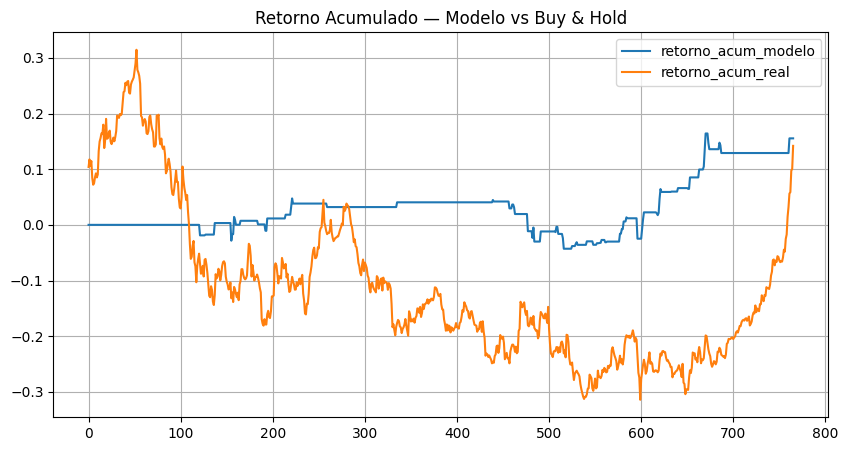

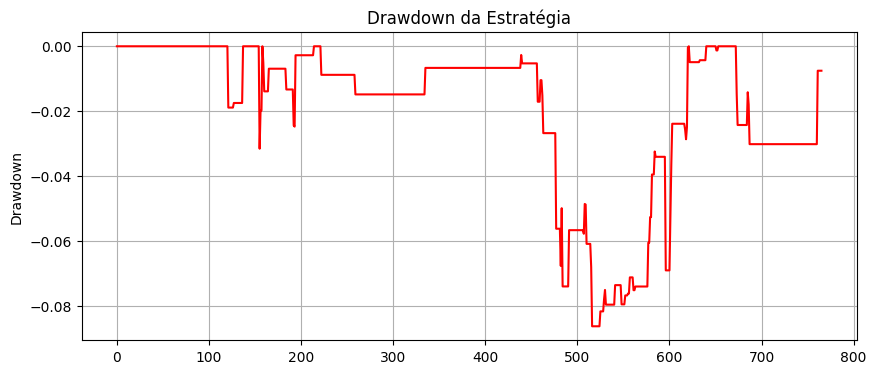


--- Main Workflow Finished ---

Final DataFrame head:
   ticker       data  preco_fechamento_ajustado  preco_fechamento  \
0  VALE3 2022-11-11                      73.35             82.30   
1  VALE3 2022-11-14                      74.25             83.31   
2  VALE3 2022-11-16                      73.47             82.44   
3  VALE3 2022-11-17                      74.06             83.10   
4  VALE3 2022-11-18                      72.04             80.83   

   preco_abertura  preco_minimo  preco_maximo  preco_medio  \
0           77.99         77.21         82.99        80.25   
1           82.39         81.38         84.44        83.06   
2           83.32         81.54         84.77        82.63   
3           80.87         80.74         83.29        82.00   
4           84.35         80.70         84.49        81.58   

   quantidade_negocios  quantidade_negociada  ...  ma_10d   ma_20d  \
0                 2841              80174100  ...  64.084  64.0370   
1                 4439

In [ ]:
def main(
    ticker: str = 'VALE3',
    start_date_str: str = '2010-01-01',
    end_date_str: str = '2023-12-31', # Note: fintz.com.br example uses only dataInicio, no end_date in params
    api_key: str = 'varos_9e52082dcd5a5fa1086bb87dc3bafdf9',
    base_url_fintz_api: str = 'https://api.fintz.com.br/bolsa/b3/avista/cotacoes/historico',
    split_ratio: float = 0.8,
    lstm_window: int = 20,
    quantile: float = 0.9,
    epochs: int = 200 # Number of epochs for LSTM training
) -> pd.DataFrame | None:
    """
    Main function to run the entire stock prediction and backtesting workflow.

    Parameters
    ----------
    ticker : str
        Stock ticker symbol (e.g., 'VALE3').
    start_date_str : str
        Start date for data ingestion (YYYY-MM-DD).
    end_date_str : str
        End date for data ingestion (YYYY-MM-DD). (Note: fintz.com.br API may not use this for historical data).
    api_key : str
        API authentication key for fintz.com.br.
    base_url_fintz_api : str
        Base URL for the fintz.com.br API endpoint.
    split_ratio : float
        Ratio for temporal train-test split.
    lstm_window : int
        Window size for creating LSTM sequences.
    quantile : float
        Quantile for dynamic thresholding in backtesting strategy.
    epochs : int
        Number of epochs to train the LSTM model.

    Returns
    -------
    pd.DataFrame or None
        DataFrame with final strategy returns, or None if data loading fails.
    """

    print("--- Starting Main Workflow ---")
    df = None

    # 1.0 Data Ingestion
    print("\n1.0 Data Ingestion")
    # IMPORTANT NOTE: The `load_stock_data_from_api` function (defined in cell uFlSut9D_Okg)
    # expects parameters like 'start_date', 'end_date' and constructs an 'Authorization: Bearer' header.
    # However, the 'fintz.com.br' API (as successfully called in cell lwUdQI-doIWe)
    # expects 'dataInicio' in params and an 'X-API-KEY' header.
    # Calling `load_stock_data_from_api` as is with the `fintz.com.br` API will likely result in an error
    # due to this parameter and header mismatch in its current implementation.
    # For the purpose of demonstrating how to integrate 'all functions created' into main,
    # we first attempt to call `load_stock_data_from_api`. If it fails, we use a direct requests call
    # that is compatible with the fintz.com.br API and replicates the working logic from cell lwUdQI-doIWe.
    try:
        print(f"Attempting to load data using `load_stock_data_from_api` for {ticker}...")
        # Pass parameters as expected by the function's signature.
        df = load_stock_data_from_api(
            base_url=base_url_fintz_api,
            ticker=ticker,
            start_date=start_date_str,
            end_date=end_date_str,
            api_key=api_key # This key will be used as 'Bearer {api_key}' inside the function.
        )
        print(f"Data loaded for {ticker} from {start_date_str} to {end_date_str} using `load_stock_data_from_api`. Shape: {df.shape}")
    except Exception as e:
        print(f"Error using `load_stock_data_from_api`: {e}")
        print("Falling back to direct API call logic (as demonstrated in cell lwUdQI-doIWe) for compatibility with fintz.com.br API.")

        # Replicate the working logic from cell lwUdQI-doIWe
        HEADERS_FINTZ = {'accept': 'application/json', 'X-API-KEY': api_key}
        PARAMS_FINTZ = {'ticker': ticker, 'dataInicio': start_date_str}
        # Note: The original example for fintz.com.br only uses 'dataInicio', not 'dataFim'.

        res_fintz = requests.get(base_url_fintz_api, headers=HEADERS_FINTZ, params=PARAMS_FINTZ)

        if res_fintz.status_code == 200:
            df = pd.DataFrame(res_fintz.json())
            # Ensure column names are consistent with the function `load_stock_data_from_api` output.
            # `load_stock_data_from_api` converts column names; apply similar transformation.
            df.columns = (df.columns.str.replace(r'([a-z])([A-Z])', r'\1_\2', regex=True).str.lower())
            print(f"Data loaded via direct API call for {ticker} from {start_date_str}. Shape: {df.shape}")
        else:
            print(f"Error: Direct API request failed with status code {res_fintz.status_code}")
            print(res_fintz.json())
            return None # Indicate failure

    if df is None or df.empty:
        print("Failed to load data. Exiting main workflow.")
        return None

    # 2.0 Data Preparation
    print("\n2.0 Data Preparation")
    df_prepared = prepare_dataframe(df.copy())
    print(f"Data prepared. Shape: {df_prepared.shape}")

    # 3.0 Feature Engineering
    print("\n3.0 Feature Engineering")
    df_features = add_features(df_prepared.copy())
    print(f"Features added. Shape: {df_features.shape}")

    # 4.0 Train-Test Split
    print("\n4.0 Train-Test Split")
    X_train_scaled, X_test_scaled, y_train, y_test, split_idx = temporal_train_test_split(
        df_features.copy(), target_col='target', split_ratio=split_ratio
    )
    print(f"Train-test split complete. Train samples: {X_train_scaled.shape[0]}, Test samples: {X_test_scaled.shape[0]}")

    # Create sequences for LSTM
    print("\nCreating sequences for LSTM model...")
    X_train_seq, y_train_seq = make_sequences(X_train_scaled, y_train, window=lstm_window)
    X_test_seq, y_test_seq = make_sequences(X_test_scaled, y_test, window=lstm_window)
    print(f"LSTM sequences created. Train sequence shape: {X_train_seq.shape}, Test sequence shape: {X_test_seq.shape}")

    # 5.0 Build and Train LSTM Model
    print("\n5.0 Building and Training LSTM Model")
    input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
    lstm_model = build_lstm_model(input_shape)
    print("LSTM Model built.")

    # Train the model
    print(f"Training LSTM model for {epochs} epochs...")
    history = lstm_model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=32,
        validation_split=0.2,
        verbose=0 # Suppress verbose output during training in main
    )
    print("LSTM Model trained.")

    # Evaluate the model
    loss, accuracy, auc = lstm_model.evaluate(X_test_seq, y_test_seq, verbose=0)
    print(f"LSTM Model Evaluation on Test Set: Loss={loss:.4f}, Accuracy={accuracy:.4f}, AUC={auc:.4f}")

    # Predict probabilities
    y_pred_prob = lstm_model.predict(X_test_seq, verbose=0).flatten()
    print("Predictions made.")

    # Align predictions with the original test dataframe for backtesting
    # The `make_sequences` function shifts the target by `lstm_window` days.
    # The original test set starts from `split_idx`. So, the backtest dataframe
    # should start from `split_idx + lstm_window` to align with `y_test_seq` and `y_pred_prob`.
    df_backtest_base = df_features.iloc[split_idx + lstm_window:].copy().reset_index(drop=True)
    df_backtest_base['target_actual'] = y_test_seq # Add actual target for reference

    # 6.0 Backtesting Strategy
    print("\n6.0 Backtesting Strategy")
    df_backtested = backtest_strategy(df_backtest_base.copy(), y_pred_prob, quantile=quantile)
    print(f"Strategy backtested with quantile: {quantile}")

    # 7.0 Metrics
    print("\n7.0 Metrics")

    # Compute hits and errors
    df_metrics = compute_hits_and_errors(df_backtested.copy())
    acertos, erros = hit_error_metrics(df_metrics)
    print(f"Hit Rate (Acertos): {acertos:.2%}")
    print(f"Error Rate (Erros): {erros:.2%}")

    # Compute absolute returns and expected value
    df_metrics = compute_absolute_returns(df_metrics)
    exp_mat, media_lucros_perdas = expected_value(df_metrics)
    print(f"Expected Value per Trade: {exp_mat:.4f}")
    print(f"Average Gains (True): {media_lucros_perdas.get(True, 0):.4f}")
    print(f"Average Losses (False): {media_lucros_perdas.get(False, 0):.4f}")

    # Compute strategy returns and Sharpe Ratio
    df_final_returns = compute_strategy_returns(df_backtested.copy())
    # Sharpe ratio for days model made a trade
    sharpe_model_trades = sharpe_ratio(df_final_returns[df_final_returns['signal'] == 1]['retorno_modelo'])
    # Sharpe ratio for the entire model return stream (includes zero returns on non-trade days)
    sharpe_overall_model = sharpe_ratio(df_final_returns['retorno_modelo'])
    sharpe_buy_hold = sharpe_ratio(df_final_returns['retorno_1d'])
    print(f"Sharpe Ratio (Model trades only): {sharpe_model_trades:.4f}")
    print(f"Sharpe Ratio (Overall Model): {sharpe_overall_model:.4f}")
    print(f"Sharpe Ratio (Buy & Hold): {sharpe_buy_hold:.4f}")

    # Plot results
    print("\nPlotting results...")
    plot_cumulative_returns(df_final_returns)
    plot_drawdown(df_final_returns['retorno_modelo'])

    print("\n--- Main Workflow Finished ---")
    return df_final_returns


# Execute the main function if the script is run directly
if __name__ == "__main__":
    final_df = main()
    if final_df is not None:
        print("\nFinal DataFrame head:\n", final_df.head())
        print("Final DataFrame tail:\n", final_df.tail())
